# 参考  
https://github.com/ypwhs/captcha_break/cnn_2019.ipynb
tensorflow 库版本1.15，更好

# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

```sh
pip install captcha numpy matplotlib tensorflow-gpu
```

In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
# characters = string.digits + string.ascii_uppercase
characters = string.ascii_uppercase+ string.ascii_lowercase
print(characters)

width, height, n_len, n_class = 128, 64, 4, len(characters)

ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


# 防止 tensorflow 占用所有显存

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K

config = tf.ConfigProto()

##########这里的版本可能有问题，提示错误module 'tensorflow' has no attribute 'ConfigProto'：
# 如果使用2.1或2.2有问题，用tensorflow

config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [3]:
Config=tf.ConfigProto(allow_soft_placement=True)  ##:如果你指定的设备不存在,允许TF自动分配设备
Config.gpu_options.allow_growth=True  ##动态分配内存
sess=tf.session(config=config)

AttributeError: module 'tensorflow' has no attribute 'session'

# 定义数据生成器

In [4]:
from tensorflow.keras.utils import Sequence

class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len=4, width=128, height=64):
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = [np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(self.generator.generate_image(random_str)) / 255.0
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, self.characters.find(ch)] = 1
        return X, y

# 测试生成器

Text(0.5, 1.0, 'umOP')

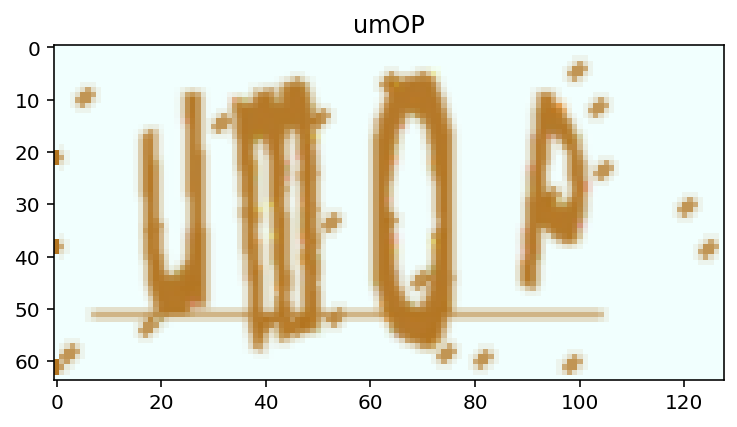

In [5]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

data = CaptchaSequence(characters, batch_size=1, steps=1)
X, y = data[0]
plt.imshow(X[0])
plt.title(decode(y))

# 定义网络结构

In [6]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# 网络结构可视化

可视化需要安装下面的包：

```sh
pip install pydot
sudo apt install graphviz
```

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

import os
os.environ['PATH']+=os.pathsep+"C:\\LocalTempFiles\\Graphviz\\bin"

plot_model(model, to_file='cnn.png', show_shapes=True)
Image('cnn.png')

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 128, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 128, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

# 训练模型

In [1]:
# 查看GPU是否在用
import tensorflow as tf
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

# 作者：猪了个去
# 链接：https://www.zhihu.com/question/263850405/answer/274242064
# 来源：知乎
# 著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。

Device mapping:

[[22. 28.]
 [49. 64.]]


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

# train_data = CaptchaSequence(characters, batch_size=128, steps=1000)
# valid_data = CaptchaSequence(characters, batch_size=128, steps=100)

train_data = CaptchaSequence(characters, batch_size=128, steps=1000)
valid_data = CaptchaSequence(characters, batch_size=128, steps=100)

callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv'), ModelCheckpoint('cnn_best.h5', save_best_only=True)]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-3, amsgrad=True), 
              metrics=['accuracy'])

# 原来的代码，model.fit_generator改为model.fit()，epochs 1000改为1，use_multiprocessing true改为false, 否则会报错
# model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,
#                     callbacks=callbacks) 

# use_multiprocessing=False，1000轮经过近3小时
# model.fit(train_data, epochs=1, validation_data=valid_data, workers=4, use_multiprocessing=True,
#                     callbacks=callbacks)


model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=2, use_multiprocessing=False,
                    callbacks=callbacks) 


Epoch 1/100
1000/1000 [==============================] - 9552s 10s/step - loss: 6.9461 - c1_loss: 1.6685 - c2_loss: 1.8212 - c3_loss: 1.8156 - c4_loss: 1.6408 - c1_acc: 0.5721 - c2_acc: 0.5331 - c3_acc: 0.5338 - c4_acc: 0.5800 - val_loss: 0.6979 - val_c1_loss: 0.1173 - val_c2_loss: 0.2454 - val_c3_loss: 0.2357 - val_c4_loss: 0.0995 - val_c1_acc: 0.9590 - val_c2_acc: 0.9226 - val_c3_acc: 0.9255 - val_c4_acc: 0.9663
Epoch 2/100
1000/1000 [==============================] - 9214s 9s/step - loss: 0.3825 - c1_loss: 0.0761 - c2_loss: 0.1160 - c3_loss: 0.1156 - c4_loss: 0.0748 - c1_acc: 0.9741 - c2_acc: 0.9610 - c3_acc: 0.9609 - c4_acc: 0.9740 - val_loss: 0.6026 - val_c1_loss: 0.1373 - val_c2_loss: 0.1617 - val_c3_loss: 0.1695 - val_c4_loss: 0.1340 - val_c1_acc: 0.9613 - val_c2_acc: 0.9488 - val_c3_acc: 0.9482 - val_c4_acc: 0.9588
Epoch 3/100
 294/1000 [=======>......................] - ETA: 1:42:49 - loss: 0.2766 - c1_loss: 0.0601 - c2_loss: 0.0787 - c3_loss: 0.0838 - c4_loss: 0.0539 - c1_acc

### 载入最好的模型继续训练一会

In [ ]:
model.load_weights('cnn_best.h5')

callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv', append=True), 
             ModelCheckpoint('cnn_best.h5', save_best_only=True)]


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-4, amsgrad=True), 
              metrics=['accuracy'])

# Incompatible shapes 实把这个metrics=['accuracy'] 去掉就可以了， 这其实是2.2.4版本的bug，可以选择降级
# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(1e-4, amsgrad=True))

# model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,
#                     callbacks=callbacks)

model.fit(train_data, epochs=1, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

In [ ]:
model.load_weights('cnn_best.h5')

# 测试模型

In [ ]:
X, y = data[0]
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# 计算模型总体准确率

In [ ]:
from tqdm import tqdm
def evaluate(model, batch_num=100):
    batch_acc = 0
    with tqdm(CaptchaSequence(characters, batch_size=128, steps=100)) as pbar:
        for X, y in pbar:
            y_pred = model.predict(X)
            y_pred = np.argmax(y_pred, axis=-1).T
            y_true = np.argmax(y, axis=-1).T

            batch_acc += (y_true == y_pred).all(axis=-1).mean()
    return batch_acc / batch_num

evaluate(model)

# 保存模型

In [ ]:
model.save('cnn.h5', include_optimizer=False)

# 可视化训练曲线

```sh
pip install pandas
```

In [ ]:
import pandas as pd

df = pd.read_csv('cnn.csv')
df[['loss', 'val_loss']].plot()

In [ ]:
df[['loss', 'val_loss']].plot(logy=True)